# ZKsync data exploration - Contracts and events

#### [Maria Silva](https://github.com/misilva73), July 2024

This notebook looks into contract deployment and events for ZKsync over almost 1 year. We use one main source of data - transaction logs. We also load block data to extract timestamps. This notebook should be an example of interacting and processing our [ZKsync public datasets](https://data.zksync.dev).

## Import packages

In [1]:
import os
import time
import pandas as pd
import polars as pl
import plotly.express as px
import plotly.graph_objects as go

In [2]:
pd.set_option('display.max_colwidth', 100)

In [3]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

Note that these are support functions defined in the `src` folder:

In [4]:
from plot_utils import get_plotly_layout, colors, update_plotly_layout_in_place
from utils import events_dict

width, height = 800, 450

Sometimes, plotly takes some time to load Mathjax library, which messes with the pdf saves. This next cell is only here to save a garbage plot and guarantee that, for the actual final plots, the library is already loaded.

In [5]:
fig=px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.write_image("some_figure.pdf", format="pdf")
time.sleep(2)
os.remove("some_figure.pdf")

##  Load Polars DataFrames

Since the dataset is quite large, we are using polars to process the data. We first compute daily aggregates and then convert these smaller aggregated datasets into pandas DataFrames we can more easily use and plot.

In [6]:
# Set directory paths
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
plots_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "plots", "contract_events_example"))

# Set block limits
block_start = 56_1367 # starting on April 1st to ignore weird blocks during era launch
block_end = 29_710_983

In [7]:
# Load blocks data
blocks_path = os.path.join(data_dir, "blocks", "blocks_*.parquet")
blocks_lazy_df = (
    pl.scan_parquet(blocks_path)
    .filter(pl.col("number").is_between(block_start, block_end))
    .with_columns(pl.from_epoch("timestamp", time_unit="s"))
    .with_columns(pl.col("timestamp").cast(pl.Date).alias("day"))
    .sort("timestamp")
)
blocks_lazy_df.schema

OrderedDict([('hash', String),
             ('parentHash', String),
             ('sha3Uncles', String),
             ('miner', String),
             ('stateRoot', String),
             ('transactionsRoot', String),
             ('receiptsRoot', String),
             ('number', Int64),
             ('l1BatchNumber', String),
             ('gasUsed', Int64),
             ('gasLimit', Int64),
             ('baseFeePerGas', Int64),
             ('extraData', String),
             ('logsBloom', String),
             ('timestamp', Datetime(time_unit='us', time_zone=None)),
             ('l1BatchTimestamp', String),
             ('difficulty', Int64),
             ('totalDifficulty', Int64),
             ('sealFields', List(Null)),
             ('uncles', List(Null)),
             ('size', Int64),
             ('mixHash', String),
             ('nonce', String),
             ('day', Date)])

In [8]:
# Create temp df to join timestamps and date
temp_blocks_df = (
    blocks_lazy_df.select(pl.col("number"), pl.col("timestamp"), pl.col("day"))
)

# Load logs data
logs_path = os.path.join(data_dir, "logs", "logs_*.parquet")
logs_lazy_df = (
    pl.scan_parquet(logs_path)
    .filter(pl.col("blockNumber").is_between(block_start, block_end))
    .join(temp_blocks_df, left_on="blockNumber", right_on="number")
)
logs_lazy_df.schema

OrderedDict([('address', String),
             ('blockHash', String),
             ('blockNumber', Int64),
             ('data', String),
             ('l1BatchNumber', String),
             ('logIndex', Int64),
             ('logType', Null),
             ('removed', Boolean),
             ('transactionHash', String),
             ('transactionIndex', Int64),
             ('transactionLogIndex', String),
             ('topics_0', String),
             ('topics_1', String),
             ('topics_2', String),
             ('topics_3', String),
             ('timestamp', Datetime(time_unit='us', time_zone=None)),
             ('day', Date)])

## Events overview

In [9]:
hash_events_df = (
    logs_lazy_df
    .select(pl.col("topics_0").alias("event_hash"))
    .group_by("event_hash")
    .len(name="event_count")
    .collect(streaming=True)
    .to_pandas()
    .sort_values("event_count", ascending=False)
)
hash_events_df["event_name"] = hash_events_df["event_hash"].apply(lambda x: events_dict[x]['name'] if x in events_dict else 'Unknown')
hash_events_df["event_percentage"] = hash_events_df["event_count"]/hash_events_df["event_count"].sum()
hash_events_df.head()

,event_hash,event_count,event_name,event_percentage
11194,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef,1464855003,Transfer,0.727881
10810,0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925,120828417,Approval,0.060039
2242,0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822,68931272,Swap,0.034252
2788,0xcf2aa50876cdfbb541206f89af0ee78d44a2abf8d328e37fa4917f982149848a,60455909,Sync,0.030040
1238,0xf26bfd49b39c52efaf04ee7f21ca2fdc73c680fada92ab7a8f1ea37b350bcf8c,16614885,Message,0.008256


In [10]:
events_df = (
    hash_events_df
    .groupby("event_name")
    ["event_count"]
    .sum()
    .reset_index()
    .sort_values("event_count", ascending=False)
)
events_df["event_percentage"] = events_df["event_count"]/events_df["event_count"].sum()
events_df.head()

,event_name,event_count,event_percentage
56,Transfer,1466349284,0.728623
4,Approval,120828417,0.060039
59,Unknown,102324808,0.050845
51,Swap,99432989,0.049408
53,Sync,77041287,0.038282


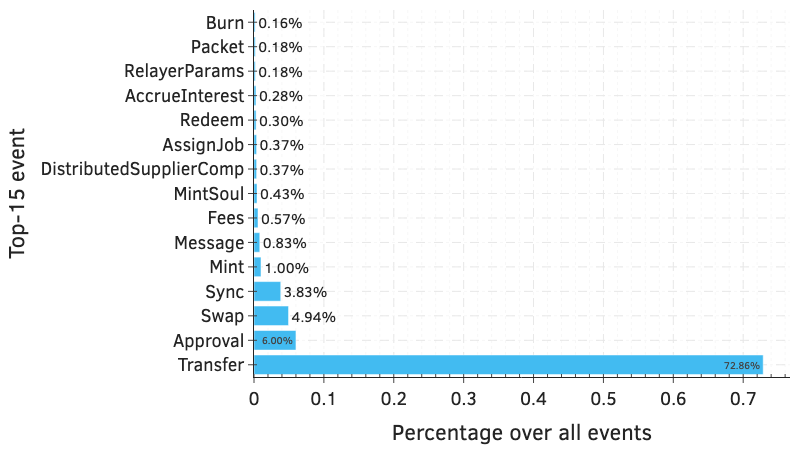

In [11]:
top_events = events_df[events_df["event_name"]!="Unknown"].iloc[:15]

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(
    go.Bar(y=top_events['event_name'], 
           x=top_events['event_percentage'],
           text=top_events['event_percentage'], 
           texttemplate='%{text:.2%}', 
           marker_color=colors['blue'],
           orientation='h'))
fig.update_layout(yaxis_title="Top-15 event",xaxis_title="Percentage over all events")
fig.write_image(os.path.join(plots_dir,'top-events.pdf'))
fig.show('png')

## Transfer events

Transfers are the most representative event type, with more than 70% of all events emitted:

In [12]:
hash_events_df[hash_events_df["event_name"]=="Transfer"]

,event_hash,event_count,event_name,event_percentage
11194,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef,1464855003,Transfer,0.727881
6702,0x69ca02dd4edd7bf0a4abb9ed3b7af3f14778db5d61921c7dc7cd545266326de2,1494281,Transfer,0.000743


The first hash represents the common transfer event (e.g. ETH, ERC-20s, etc.) and has the following topics and data:

![](../plots/contract_events_example/TransferEvent.png)

We can see the top tokens transferred by looking at the contract address that emitted the event. Note that we will merge the event data with a mapping between contract addresses and contract names we provide in the file `contract_mapping.csv`. In addition, we will process the topic fields to extract all relevant information.

In [13]:
contract_map_file =  os.path.join(data_dir, "contract_mapping.csv")
contract_map_df = pd.read_csv(contract_map_file)
contract_map_df.head()

,name,symbol,decimals,l2Address,l1Address
0,Ether,ETH,18,0x000000000000000000000000000000000000800a,0x0000000000000000000000000000000000000000
1,ChainLink Token,LINK,18,0x082fade8b84b18c441d506e1d3a43a387cc59d20,0x514910771af9ca656af840dff83e8264ecf986ca
2,Wrapped BTC,WBTC,8,0xbbeb516fb02a01611cbbe0453fe3c580d7281011,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599
3,Matic Token,MATIC,18,0x770e221ec6f3e8a2e2e168399bb3aa56a63e397d,0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0
4,Uniswap,UNI,18,0x1c6f53185061d7cc387e481c350ad00c2c876f3e,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984


In [14]:
transfer_event_hash = "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"

transfer_lazy_df = (
    logs_lazy_df
    .filter(pl.col('topics_0').str.to_lowercase().eq(transfer_event_hash))
    .select([
        pl.col('blockNumber'),
        pl.col('transactionHash'),
        pl.col('transactionIndex'),
        pl.col('logIndex'),
        pl.col('address').str.to_lowercase().alias('contract_address'),
        pl.format("0x{}", pl.col('topics_1').str.slice(-40)).alias('sender'),
        pl.format("0x{}", pl.col('topics_2').str.slice(-40)).alias('receiver'),
        pl.col('data').str.replace('0x', '0x0').alias('amount')])
)
transfer_lazy_df.schema

OrderedDict([('blockNumber', Int64),
             ('transactionHash', String),
             ('transactionIndex', Int64),
             ('logIndex', Int64),
             ('contract_address', String),
             ('sender', String),
             ('receiver', String),
             ('amount', String)])

In [15]:
transfer_df = (
    transfer_lazy_df
    .group_by(pl.col('contract_address'))
    .agg(pl.len().alias("transfer_count"))
    .collect(streaming=True)
    .to_pandas()
    .sort_values("transfer_count", ascending=False)
    .merge(contract_map_df[["l2Address", "name", "symbol"]], how="left", left_on="contract_address", right_on="l2Address")
    .fillna({"name":"Unknown", "symbol":"Unknown"})
    .drop(columns=["l2Address"])
)
transfer_df["transfer_perc"] = transfer_df["transfer_count"]/transfer_df["transfer_count"].sum()

transfer_df.head(10)

,contract_address,transfer_count,name,symbol,transfer_perc
0,0x000000000000000000000000000000000000800a,1051313562,Ether,ETH,0.717691
1,0x5aea5775959fbc2557cc8789bc1bf90a239d9a91,142265208,Wrapped Ether,WETH,0.097119
2,0x3355df6d4c9c3035724fd0e3914de96a5a83aaf4,119680249,USD Coin,USDC,0.081701
3,0x493257fd37edb34451f62edf8d2a0c418852ba4c,17476871,Tether USD,USDT,0.011931
4,0x5155704bb41fde152ad3e1ae402e8e8b9ba335d3,8700738,Soul,Soul,0.005940
5,0x80115c708e12edd42e504c1cd52aea96c547c05c,8357698,SyncSwap USDC/WETH Classic LP,USDC/WETH cSLP,0.005705
6,0x2039bb4116b4efc145ec4f0e2ea75012d6c0f181,6951968,Binance USD,BUSD,0.004746
7,0x22d8b71599e14f20a49a397b88c1c878c86f5579,3714078,EraLend Ether,eETH,0.002535
8,0xbbeb516fb02a01611cbbe0453fe3c580d7281011,3420640,Wrapped BTC,WBTC,0.002335
9,0x5f7cbcb391d33988dad74d6fd683aadda1123e4d,2732819,ReactorFusion,RF,0.001866


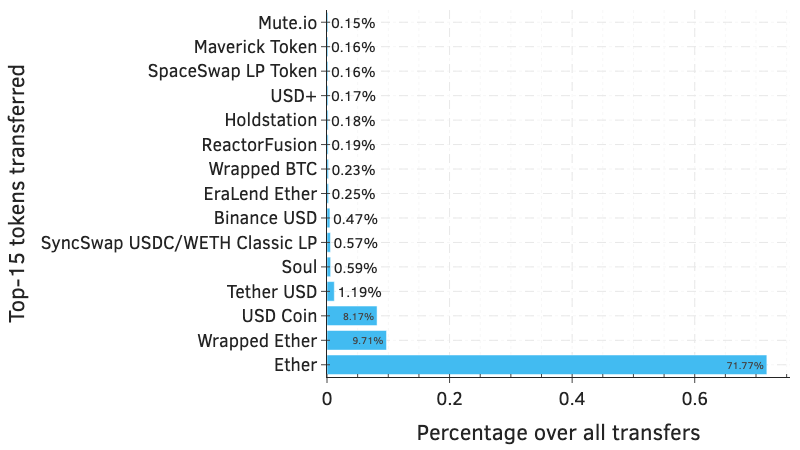

In [16]:
top_tokens = transfer_df[transfer_df["name"]!="Unknown"].iloc[:15]

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(
    go.Bar(y=top_tokens['name'], 
           x=top_tokens['transfer_perc'],
           text=top_tokens['transfer_perc'], 
           texttemplate='%{text:.2%}', 
           marker_color=colors['blue'],
           orientation='h'))
fig.update_layout(yaxis_title="Top-15 tokens transferred",xaxis_title="Percentage over all transfers")
fig.write_image(os.path.join(plots_dir,'top-tokens.pdf'))
fig.show('png')

ETH transfers are by far the most common. However, we should highlight that, in ZKsync, every transaction generates two additional ETH transfers - one for the initial payment of the transaction fees and another with a transaction fee refund (after all L1 and proving costs are accounted for). These transaction fee transfers always appear as ETH transfers from or to the address `0x0000000000000000000000000000000000008001`, so we can filter them out:

In [17]:
fee_address = "0x0000000000000000000000000000000000008001"

filtered_transfer_df = (
    transfer_lazy_df
    .filter((pl.col('sender').ne(fee_address)) & (pl.col('receiver').ne(fee_address)))
    .group_by(pl.col('contract_address'))
    .agg(pl.len().alias("transfer_count"))
    .collect(streaming=True)
    .to_pandas()
    .sort_values("transfer_count", ascending=False)
    .merge(contract_map_df[["l2Address", "name", "symbol"]], how="left", left_on="contract_address", right_on="l2Address")
    .fillna({"name":"Unknown", "symbol":"Unknown"})
    .drop(columns=["l2Address"])
)
filtered_transfer_df["transfer_perc"] = filtered_transfer_df["transfer_count"]/filtered_transfer_df["transfer_count"].sum()

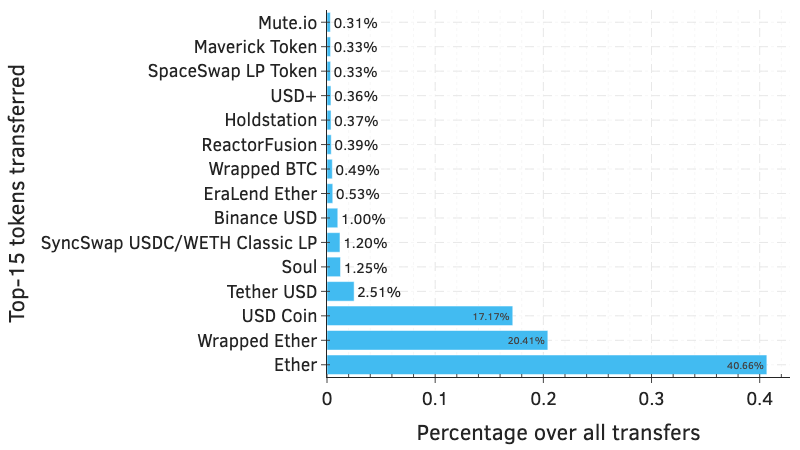

In [18]:
top_tokens = filtered_transfer_df[filtered_transfer_df["name"]!="Unknown"].iloc[:15]

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(
    go.Bar(y=top_tokens['name'], 
           x=top_tokens['transfer_perc'],
           text=top_tokens['transfer_perc'], 
           texttemplate='%{text:.2%}', 
           marker_color=colors['blue'],
           orientation='h'))
fig.update_layout(yaxis_title="Top-15 tokens transferred",xaxis_title="Percentage over all transfers")
fig.write_image(os.path.join(plots_dir,'top-tokens-filtered.pdf'))
fig.show('png')

As for the second event that has a Transfer event name, we will ignore it for now as it is only emitted by two smart-contracts that are not decoded in Etherescan:

In [19]:
temp_event_hash = "0x69ca02dd4edd7bf0a4abb9ed3b7af3f14778db5d61921c7dc7cd545266326de2"

temp_df = (
    logs_lazy_df
    .filter(pl.col('topics_0').str.to_lowercase().eq(temp_event_hash))
    .group_by("address")
    .len(name="event_count")
    .collect(streaming=True)
    .to_pandas()
)
temp_df

,address,event_count
0,0x2C13083aF23909C5DD7D4FdEf29451b95931457d,1493247
1,0xb4ab2ff34fadc774aff45f1c4566cb5e16bd4867,1034


## Approval events

Approvals are the second largest event type, with 6% of event emitted:

In [20]:
hash_events_df[hash_events_df["event_name"]=="Approval"]

,event_hash,event_count,event_name,event_percentage
10810,0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925,120828417,Approval,0.060039


Approvals have a single hash and they contain the following topics and data:

![](../plots/contract_events_example/ApprovalEvent.png)

Similarly to the transfer events, we can see which contracts are emitting these events. The top emitters are also ERC20 token contracts and these events represent an owner "approving" a spender to transfer a pre-defined amount of tokens they hold. This is common in bridged assets, for instance, as is the case of Bridged USDC (USDC.e), which is the top emitter.

In [28]:
approval_event_hash = "0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925"

approvals_df = (
    logs_lazy_df
    .filter(pl.col('topics_0').str.to_lowercase().eq(approval_event_hash))
    .group_by(pl.col('address').str.to_lowercase())
    .len(name="approvals_count")
    .collect(streaming=True)
    .to_pandas()
    .sort_values("approvals_count", ascending=False)
    .merge(contract_map_df[["l2Address", "name", "symbol"]], how="left", left_on="address", right_on="l2Address")
    .fillna({"name":"Unknown", "symbol": "Unknown"})
    .drop(columns=["l2Address"])
)
approvals_df["approvals_perc"] = approvals_df["approvals_count"]/approvals_df["approvals_count"].sum()
approvals_df.head(10)

,address,approvals_count,name,symbol,approvals_perc
0,0x3355df6d4c9c3035724fd0e3914de96a5a83aaf4,68251926,USD Coin,USDC,0.564867
1,0x5aea5775959fbc2557cc8789bc1bf90a239d9a91,7591362,Wrapped Ether,WETH,0.062828
2,0x493257fd37edb34451f62edf8d2a0c418852ba4c,7228810,Tether USD,USDT,0.059827
3,0x2039bb4116b4efc145ec4f0e2ea75012d6c0f181,4012313,Binance USD,BUSD,0.033207
4,0xed4040fd47629e7c8fbb7da76bb50b3e7695f0f2,2853788,Holdstation,HOLD,0.023619
5,0x31c2c031fdc9d33e974f327ab0d9883eae06ca4a,2013470,zkSwap Finance,ZF,0.016664
6,0x8e86e46278518efc1c5ced245cba2c7e3ef11557,1736990,USD+,USD+,0.014376
7,0xbbeb516fb02a01611cbbe0453fe3c580d7281011,1613341,Wrapped BTC,WBTC,0.013352
8,0x787c09494ec8bcb24dcaf8659e7d5d69979ee508,1544180,Maverick Token,MAV,0.012780
9,0x80115c708e12edd42e504c1cd52aea96c547c05c,1190610,SyncSwap USDC/WETH Classic LP,USDC/WETH cSLP,0.009854


In [29]:
len(approvals_df)

14754

In [30]:
sum(approvals_df["name"]=="Unknown")

4710

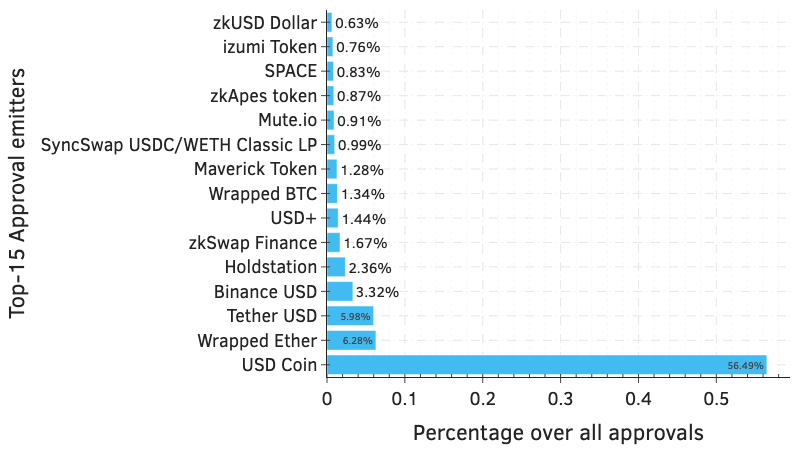

In [31]:
top_approvs = approvals_df[approvals_df["name"]!="Unknown"].iloc[:15]

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(
    go.Bar(y=top_approvs['name'], 
           x=top_approvs['approvals_perc'],
           text=top_approvs['approvals_perc'], 
           texttemplate='%{text:.2%}', 
           marker_color=colors['blue'],
           orientation='h'))
fig.update_layout(yaxis_title="Top-15 Approval emitters",xaxis_title="Percentage over all approvals")
fig.write_image(os.path.join(plots_dir,'top-approval-emitters.pdf'))
fig.show('png')

## Contract deployments

Now let's look at contract deployments. Even though it is not in the top 15 most emitted event types, it is still an important metric for network activity. In ZKsync, the contract deployment event is named `ContractDeployed` and has the following hash and event counts:

In [25]:
hash_events_df[hash_events_df["event_name"]=="ContractDeployed"]

,event_hash,event_count,event_name,event_percentage
2751,0x290afdae231a3fc0bbae8b1af63698b0a1d79b21ad17df0342dfb952fe74f8e5,1625493,ContractDeployed,0.000808


`ContractDeployed` generates the following topics and data:

![](../plots/contract_events_example/ContractDeployedEvent.png)

In [26]:
contract_deployed_event_hash = "0x290afdae231a3fc0bbae8b1af63698b0a1d79b21ad17df0342dfb952fe74f8e5"

contracts_df = (
    logs_lazy_df
    .filter(pl.col('topics_0').str.to_lowercase().eq(contract_deployed_event_hash))
    .group_by("day")
    .agg(pl.col("topics_3").count().alias("contracts_deployed"))
    .collect(streaming=True)
    .to_pandas()
    .sort_values("day")
)
contracts_df.head()

,day,contracts_deployed
314,2023-04-01,704
115,2023-04-02,1205
102,2023-04-03,1045
211,2023-04-04,988
294,2023-04-05,911


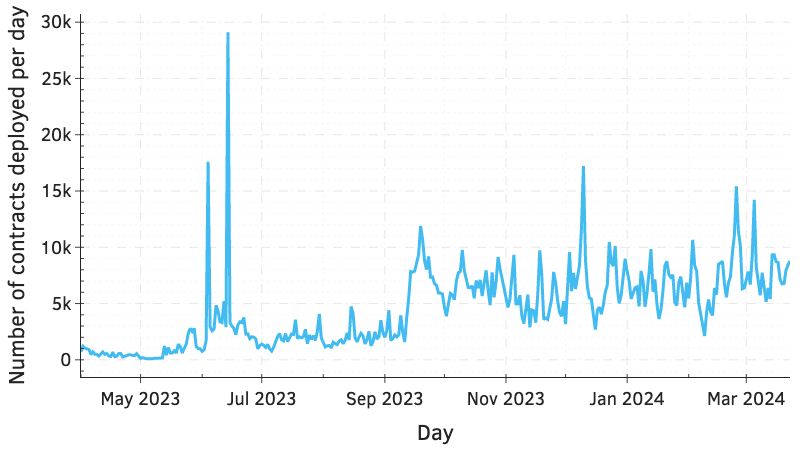

In [27]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))
fig.add_trace(go.Scatter(
    x=contracts_df['day'], 
    y=contracts_df['contracts_deployed'], 
    line=dict(color=colors['blue'], width=3, dash='solid'), mode='lines'))

fig.update_layout(xaxis_title="Day", yaxis_title="Number of contracts deployed per day")

fig.write_image(os.path.join(plots_dir,'contracts-deployed-day.pdf'))
fig.show('png')